In [147]:
import numpy as np
import pandas as pd
import os 
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2
from PIL import Image

In [148]:
train_data = pd.read_csv('./data/legend.csv')
test_data = pd.read_csv('./data/500_picts_satz.csv')

In [149]:
image_name = complete_data['image']


In [150]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

In [151]:
transform_train = transforms.Compose([ 
    transforms.Resize(256),                          # smaller edge of image resized to 256
    transforms.RandomCrop(224),                      # get 224x224 crop from random location
    transforms.RandomHorizontalFlip(),               # horizontally flip image with probability=0.5
    transforms.ToTensor(),                           # convert the PIL Image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))])

In [188]:
class EmotionDetectionDataset(Dataset):
    
      def __init__(self,csv_file,root_dir,transform=None):
            self.emotion = pd.read_csv(csv_file)
            self.root_dir = root_dir
            self.transform = transform
            
      
      def __len__(self):
            return len(self.emotion)
        
      
      def __getitem__(self,idx):
        image_name = Image.open(os.path.join(self.root_dir,
                                self.emotion.iloc[idx, 1])).convert('RGB')
        image = self.transform(image_name)


       

        emotion = self.emotion.iloc[idx, 2]
        sample = {'image': image, 'emotion': emotion}

        
        return sample
    

neutral
torch.Size([3, 224, 224])


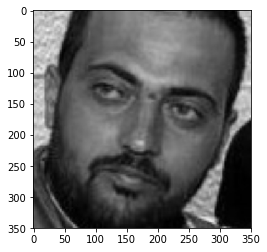

In [193]:
transformed_dataset =  EmotionDetectionDataset('./data/legend.csv','./images/',transform=transform_train)

sample = transformed_dataset[20]
print (sample['emotion'])
print(sample['image'].shape)